# Project - Vehicle Detection and Tracking

In [1]:
data_DIR = './data/small_data'

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

## Data exploration

* used small dataset

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
%matplotlib inline

# images are divided up into vehicles and non-vehicles

images = glob.glob(data_DIR + '/' +'*.jpeg')
cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 1221  cars and 1277  non-cars
of size:  (64, 64, 3)  and data type: uint8


Random sample image


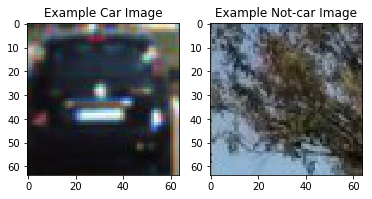

In [4]:
# Plot the examples

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

print('Random sample image')
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

## Implement Pipeline On Single Image

### Feature Extraction

#### Color-Space Histogram

In [5]:
## Extract Color histogram from imgae
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

####  HOG

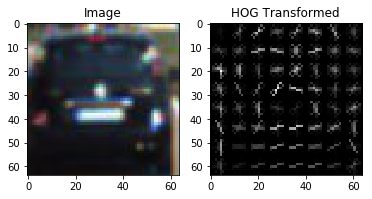

In [6]:
## Extract HOG(Histogram of Oritented Gradients) from imgae
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        normalise=None, transform_sqrt=False,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=transform_sqrt,
                                  normalise=normalise,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=transform_sqrt,
                       normalise = normalise,
                       visualise=vis, feature_vector=feature_vec)
        return features
    
    
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))

    
# Read in car / not-car images
image = mpimg.imread(cars[car_ind])

orient = 9
pix_per_cell=8
cell_per_block=2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV) # Can be RGB, HSV, LUV, HLS, YUV, YCrCb , colorspace options
feature, hog_image = get_hog_features(cvt_image[:,:,0], orient, pix_per_cell, cell_per_block,
                          vis=True, feature_vec=True)

fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Image')
plt.subplot(122)
plt.imshow(hog_image,cmap='gray')
plt.title('HOG Transformed')

#### Bin spatial

In [7]:
## Extract spatial bins from imgae
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

#### Implement feature extraction fucntion

In [8]:
## Extract features from training data set
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        img = mpimg.imread(file)
        image = cv2.resize(img, (64, 64))
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [9]:
## Extract feature from sigle image
def single_img_features(img, color_space='YUV', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

## Training Classifier

#### Train SVM

In [10]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split


color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb , colorspace options
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size=(32, 32)
hist_bins= 32
spatial_feat = True
hist_feat = True 
hog_feat = True 

In [11]:
t=time.time()
car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins = hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_feat = spatial_feat , hist_feat = hist_feat , hog_feat = hog_feat )
notcar_features = extract_features(notcars, color_space=color_space,spatial_size=spatial_size, 
                        hist_bins = hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,
                        spatial_feat = spatial_feat , hist_feat = hist_feat , hog_feat = hog_feat )

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# # Check the prediction time for a single sample
# t=time.time()
# n_predict = 10
# print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

7.71 Seconds to extract HOG features...
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4736
1.2 Seconds to train SVC...
Test Accuracy of SVC =  0.988


### Applying Sliding Windows

#### Searching Window 1

Number of windows in this region = 26


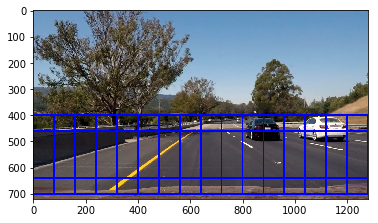

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

image = mpimg.imread('bbox-example-image2.jpg')



# region1 = {'x_start_stop':[None, None] ,
#            'y_start_stop':[int(64*6) ,int(64*12) ],
#            'window_size':(int(64*4) ,int(64*3)),
#            'window_overlap':(0.5 , 0.5)}

region1 = {'x_start_stop':[None, None] ,
           'y_start_stop':[400 ,700 ],
           'window_size':(320 ,240),
           'window_overlap':(0.75 , 0.75)}


x_start_stop = region1['x_start_stop']
y_start_stop = region1['y_start_stop']
window_size = region1['window_size']       
window_overlap = region1['window_overlap']


windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window= window_size, xy_overlap= window_overlap)
                       
print('Number of windows in this region = {}'.format(len(windows)))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

#### Searching Window 2

Number of windows in this region = 54


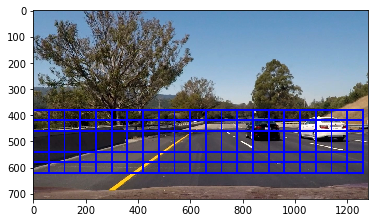

In [13]:
# region2 = {'x_start_stop':[None, None] ,
#            'y_start_stop':[int(64*6) ,int(64*9) ],
#            'window_size':(int(64*2) ,int(64*1)),
#            'window_overlap':( 0.5 , 0.5)}

region2 = {'x_start_stop':[None, None] ,
           'y_start_stop':[380 ,620],
           'window_size':(240,160),
           'window_overlap':( 0.75 , 0.75)}

x_start_stop = region2['x_start_stop']
y_start_stop = region2['y_start_stop']
window_size = region2['window_size']       
window_overlap = region2['window_overlap']



windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window= window_size, xy_overlap= window_overlap)
                       
print('Number of windows in this region = {}'.format(len(windows)))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

#### Searching Window 3

Number of windows in this region = 87


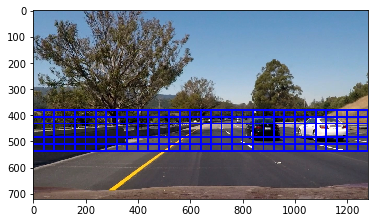

In [14]:
# region3 = {'x_start_stop':[None, None] ,
#            'y_start_stop':[int(64*6) ,int(64*8) ],
#            'window_size':(int(64*2) ,int(64*1)),
#            'window_overlap':( 0.75 , 0.5)}

region3 = {'x_start_stop':[None, None] ,
           'y_start_stop':[380 ,536],
           'window_size':(160,104),
           'window_overlap':( 0.75 , 0.75)}

x_start_stop = region3['x_start_stop']
y_start_stop = region3['y_start_stop']
window_size = region3['window_size']       
window_overlap = region3['window_overlap']

windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window= window_size, xy_overlap= window_overlap)
                       
print('Number of windows in this region = {}'.format(len(windows)))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

#### Searching Window 4

Number of windows in this region = 122


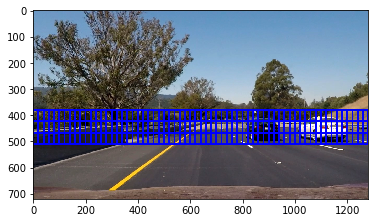

In [15]:
# region3 = {'x_start_stop':[None, None] ,
#            'y_start_stop':[int(64*6) ,int(64*8) ],
#            'window_size':(int(64*2) ,int(64*1)),
#            'window_overlap':( 0.75 , 0.5)}

region4 = {'x_start_stop':[None, None] ,
           'y_start_stop':[380 ,540],
           'window_size':(80,87),
           'window_overlap':( 0.75 , 0.5)}

x_start_stop = region4['x_start_stop']
y_start_stop = region4['y_start_stop']
window_size = region4['window_size']       
window_overlap = region4['window_overlap']

windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window= window_size, xy_overlap= window_overlap)
                       
print('Number of windows in this region = {}'.format(len(windows)))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

#### Implement Siding Window fucntion

Total number of windows = 289


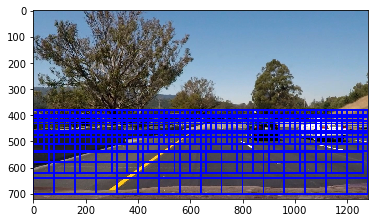

In [16]:
# window_regions =[region1,region2,region3,region4]

## get search windows from a image
def get_windows(img):    
        
    region1 = {'x_start_stop':[None, None] ,
           'y_start_stop':[400 ,700 ],
           'window_size':(320 ,240),
           'window_overlap':(0.75 , 0.75)}

    region2 = {'x_start_stop':[None, None] ,
               'y_start_stop':[380 ,620],
               'window_size':(240,160),
               'window_overlap':( 0.75 , 0.75)}

    region3 = {'x_start_stop':[None, None] ,
               'y_start_stop':[380 ,536],
               'window_size':(160,104),
               'window_overlap':( 0.75 , 0.75)}
    
#     region4 = {'x_start_stop':[None, None] ,
#            'y_start_stop':[400 ,490],
#            'window_size':(80,72),
#            'window_overlap':( 0.75 , 0.75)}
    region4 = {'x_start_stop':[None, None] ,
               'y_start_stop':[380 ,540],
               'window_size':(80,87),
               'window_overlap':( 0.75 , 0.5)}
    
    window_regions =[region1,region2,region3,region4]
    
    windows = []    
    for region in window_regions :
        x_start_stop = region['x_start_stop']
        y_start_stop = region['y_start_stop']
        window_size = region['window_size']       
        window_overlap = region['window_overlap']
        
        region_windows = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window= window_size, xy_overlap= window_overlap)
        windows.extend(region_windows)
    
    return windows


windows = get_windows(image)

print('Total number of windows = {}'.format(len(windows)))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

#### Detect Cars

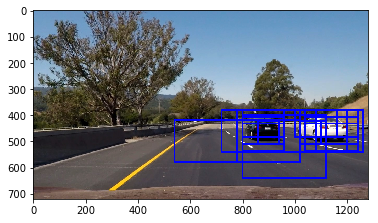

In [17]:
## find hot windows which there is a car feature from windows list
def search_windows(img, windows, clf=None, scaler=None, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    #8) Return windows for positive detections
    return on_windows

hot_windows = search_windows(image, windows, clf = svc, scaler = X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)   

plt.imshow(window_img)

### Draw Heatmap
* Remove false positive and draw box on cars detected

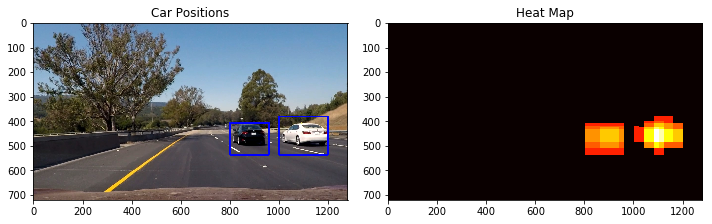

In [27]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def heatmap_search(img , hot_windows, threshold=3):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat,threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img , heatmap

draw_img , heatmap = heatmap_search(image , hot_windows)


fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

### Final Pipeline
* Implement pipeline_find_car() which find a car from image and draw box on it.

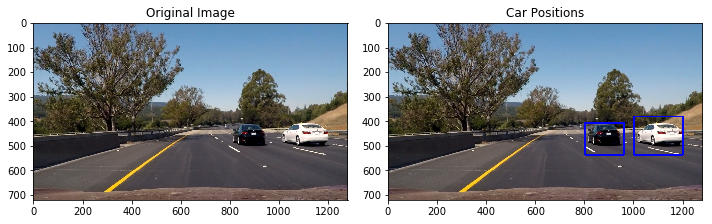

In [28]:
# color_space = 'YCrCb'
# orient = 9  
# pix_per_cell = 8
# cell_per_block = 2 
# hog_channel = 0 
# spatial_size = (32, 32)
# hist_bins = 32    
# spatial_feat = True 
# hist_feat = True 
# hog_feat = True 

# parameters = {'color_space' : 'YCrCb',
#             'orient' : 9,  
#             'pix_per_cell' : 8 ,
#             'cell_per_block' : 2 ,
#             'hog_channel' : 0 ,
#             'spatial_size' : (32, 32) ,
#             'hist_bins' : 32 ,   
#             'spatial_feat' : True ,
#             'hist_feat' : True,
#             'hog_feat' : True,
#             'svc': svc, 
#             'X_scaler' : X_scaler }

parameters = {'color_space' : color_space,
            'orient' : orient,  
            'pix_per_cell' : pix_per_cell ,
            'cell_per_block' : cell_per_block ,
            'hog_channel' : hog_channel ,
            'spatial_size' : spatial_size ,
            'hist_bins' : hist_bins ,   
            'spatial_feat' : spatial_feat ,
            'hist_feat' : hist_feat,
            'hog_feat' : hog_feat,
            'svc': svc, 
            'X_scaler' : X_scaler }

# def pipeline_find_cars(image , parameters):
    
## find cars and draw box on it
def pipeline_find_cars(img):
    
    color_space = parameters['color_space'] 
    orient = parameters['orient']  
    pix_per_cell = parameters['pix_per_cell'] 
    cell_per_block = parameters['cell_per_block'] 
    hog_channel = parameters['hog_channel'] 
    spatial_size = parameters['spatial_size']
    hist_bins = parameters['hist_bins']    
    spatial_feat = parameters['spatial_feat'] 
    hist_feat = parameters['hist_feat'] 
    hog_feat = parameters['hog_feat'] 
    svc = parameters['svc']
    X_scaler = parameters['X_scaler']
    
    windows = get_windows(img)
    hot_windows = search_windows(img, windows, clf = svc, scaler = X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    draw_img , heatmap = heatmap_search(img , hot_windows)
              
    return draw_img

image = mpimg.imread('bbox-example-image2.jpg')
# cars_img = pipeline_find_cars(image , parameters)
cars_img = pipeline_find_cars(image)
    
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(122)
plt.imshow(cars_img)
plt.title('Car Positions')

fig.tight_layout()

## Test On Video

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Test Video

In [25]:
## make car detection video using pipeline
output1 = 'project_video_part2_result.mp4'
clip1 = VideoFileClip("project_video_part2.mp4")
white_clip = clip1.fl_image(pipeline_find_cars) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output1, audio=False)

HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output1))

[MoviePy] >>>> Building video project_video_part2_result.mp4
[MoviePy] Writing video project_video_part2_result.mp4


 99%|█████████▉| 98/99 [01:22<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_part2_result.mp4 

Wall time: 1min 23s


####  Project Video

In [22]:
output2 = 'project_video_output.mp4'
clip2 = VideoFileClip("project_video.mp4")
white_clip = clip2.fl_image(pipeline_find_cars) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output2, audio=False)

HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(output2))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [17:42<00:00,  1.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 17min 43s
